### 05 - Inference yoga pose detection

In [123]:
import pandas as pd
import numpy as np
from ultralytics import YOLO
import pickle
from scipy import stats
import matplotlib.pyplot as plt
from PIL import Image

#### Stap 1. Video inladen

In [124]:
file = 'C:\\Users\\joost.vanstreels\\PycharmProjects\\YOLOv8\\runs\\DATASET HM\\INFERENCE\\Video lower Joost.mp4'
file

'C:\\Users\\joost.vanstreels\\PycharmProjects\\YOLOv8\\runs\\DATASET HM\\INFERENCE\\Video lower Joost.mp4'

#### Stap 2. Keypoints genereren met YOLO

In [125]:
# Keuze uit verschillende modellen
model = YOLO('yolov8m-pose.pt')
#model = YOLO('yolov8n-pose.pt')

In [126]:
results_inference = model.predict(file, save=True, vid_stride=5, conf=0.5)



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/114) C:\Users\joost.vanstreels\PycharmProjects\YOLOv8\runs\DATASET HM\INFERENCE\Video lower Joost.mp4: 640x384 1 person, 487.1ms
video 1/1 (2/114) C:\Users\joost.vanstreels\PycharmProjects\YOLOv8\runs\DATASET HM\INFERENCE\Video lower Joost.mp4: 640x384 1 person, 411.2ms
video 1/1 (3/114) C:\Users\joost.vanstreels\PycharmProjects\YOLOv8\runs\DATASET HM\INFERENCE\Video lower Joost.mp4: 640x384 1 person, 481.0ms
video 1/1 (4/114) C:\Users\joost

#### Stap 3. Data postprocessing


In [127]:
# Image source, 17x2 keypoints, 17 confidences per keypoint opslaan in array
analytics_data = np.empty([1, 53])
i = 0
for r in results_inference:
    # De has_visible check controleert of er een persoon gedetecteerd is
    if r.keypoints.has_visible == True:
        frame_number = np.array([[i]])
        confidence = np.array([r.__getitem__(0).boxes.conf])
        keypoints = np.array([r.__getitem__(0).keypoints.xyn.numpy().flatten()])
        confidences = np.array([r.__getitem__(0).keypoints.conf.numpy().flatten()])

        # Combineer informatie van elk plaatje in 1 x 55 array (rij)
        new_row = np.concatenate((frame_number, confidence, keypoints, confidences), axis=1)

        # Voeg de rij toe in een array
        analytics_data = np.vstack((analytics_data, new_row))
    i = i + 1

In [128]:
# Verwijder de eerste rij uit het array
analytics_data = np.delete(analytics_data, 0, 0)
analytics_data

array([[          0,     0.94864,     0.53254, ...,      0.8171,     0.08841,    0.073903],
       [          1,      0.9534,     0.48043, ...,     0.89858,     0.15633,     0.13926],
       [          2,     0.95356,     0.46159, ...,     0.84497,    0.095992,    0.091039],
       ...,
       [        111,     0.95544,     0.48041, ...,     0.67045,    0.010217,    0.023973],
       [        112,      0.9579,     0.42772, ...,     0.49205,   0.0073702,     0.01688],
       [        113,     0.95638,     0.44622, ...,     0.57426,    0.010194,    0.023936]])

In [129]:
# Dataframe maken met alle gegevens uit het array
colnames = ['frame_number', 'confidence', 'x_nose', 'y_nose','x_left_eye','y_left_eye','x_right_eye','y_right_eye','x_left_ear','y_left_ear','x_right_ear','y_right_ear','x_left_shoulder','y_left_shoulder','x_right_shoulder','y_right_shoulder','x_left_elbow', 'y_left_elbow','x_right_elbow','y_right_elbow','x_left_wrist','y_left_wrist', 'x_right_wrist','y_right_wrist','x_left_hip','y_left_hip','x_right_hip','y_right_hip','x_left_knee','y_left_knee','x_right_knee','y_right_knee','x_left_ankle','y_left_ankle','x_right_ankle','y_right_ankle','c_nose','c_left_eye','c_right_eye','c_left_ear','c_right_ear','c_left_shoulder','c_right_shoulder','c_left_elbow','c_right_elbow','c_left_wrist','c_right_wrist','c_left_hip','c_right_hip','c_left_knee','c_right_knee','c_left_ankle','c_right_ankle']

analytics_df = pd.DataFrame(data = analytics_data, columns=colnames)
analytics_df

,frame_number,confidence,x_nose,y_nose,x_left_eye,y_left_eye,x_right_eye,y_right_eye,x_left_ear,y_left_ear,...,c_left_elbow,c_right_elbow,c_left_wrist,c_right_wrist,c_left_hip,c_right_hip,c_left_knee,c_right_knee,c_left_ankle,c_right_ankle
0,0.0,0.948635,0.532544,0.154188,0.575325,0.136733,0.500441,0.136890,0.635577,0.169601,...,0.991302,0.972646,0.971030,0.932136,0.998208,0.997225,0.871112,0.817100,0.088410,0.073903
1,1.0,0.953399,0.480433,0.162023,0.521330,0.145493,0.447870,0.145556,0.579495,0.177104,...,0.992468,0.981523,0.976287,0.954812,0.998869,0.998416,0.921413,0.898582,0.156326,0.139263
2,2.0,0.953557,0.461588,0.171726,0.500398,0.154447,0.429181,0.154634,0.554720,0.183328,...,0.989057,0.978981,0.968237,0.949341,0.998305,0.997809,0.871161,0.844969,0.095992,0.091039
3,3.0,0.952209,0.467307,0.180740,0.505266,0.162544,0.434651,0.163596,0.561320,0.187323,...,0.987610,0.982160,0.965936,0.955182,0.998409,0.998173,0.891872,0.882102,0.117936,0.119576
4,4.0,0.944365,0.478052,0.197625,0.514143,0.177646,0.442411,0.178925,0.569605,0.193288,...,0.978754,0.978104,0.945408,0.948117,0.997292,0.997269,0.853198,0.865643,0.100323,0.114940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,109.0,0.968808,0.413357,0.013434,0.464478,0.000000,0.371370,0.000000,0.546722,0.010409,...,0.967421,0.973689,0.931819,0.944556,0.998715,0.998767,0.710248,0.731699,0.028789,0.035356
110,110.0,0.965247,0.435537,0.065602,0.476906,0.039041,0.397029,0.046724,0.538371,0.003818,...,0.936684,0.962233,0.916682,0.955497,0.995203,0.996023,0.534080,0.591944,0.018907,0.022356
111,111.0,0.955437,0.480407,0.045438,0.525742,0.019033,0.437795,0.024378,0.574121,0.000000,...,0.655583,0.986283,0.655624,0.972629,0.993001,0.998209,0.358070,0.670445,0.010217,0.023973
112,112.0,0.957897,0.427715,0.044584,0.471126,0.015004,0.379707,0.027308,0.545028,0.000000,...,0.580212,0.972278,0.636071,0.961053,0.976627,0.993109,0.221829,0.492053,0.007370,0.016880


In [130]:
# Types omzetten
analytics_df = analytics_df.apply(pd.to_numeric, errors='coerce')

In [131]:
# Data normaliseren

# Eerst wordt het torso bepaald
# Hoogste punt torso: laagste waarde van beide schouders
analytics_df['torso_top'] = analytics_df[['y_left_shoulder', 'y_right_shoulder']].min(axis=1)
# Laagste punt torso: hoogste waarde van beide heupen
analytics_df['torso_bottom'] = analytics_df[['y_left_hip', 'y_right_hip']].max(axis=1)
# Meest linkse punt torso (merk op: dit gaat dus over de rechterschouder en rechterheup!
analytics_df['torso_left'] = analytics_df[['x_right_shoulder', 'x_right_hip']].min(axis=1)
# Meest rechtse punt torso
analytics_df['torso_right'] = analytics_df[['x_left_shoulder', 'x_left_hip']].max(axis=1)

# Het middelpunt van het torso
analytics_df['torso_center_x'] = analytics_df[['torso_left', 'torso_right']].mean(axis=1)
analytics_df['torso_center_y'] = analytics_df[['torso_bottom', 'torso_top']].mean(axis=1)

# De hoogte van het torso wordt waarde 1, de schaalfactor om te rekenen wordt hier berekend
analytics_df['scale_factor'] = 1 / (analytics_df['torso_bottom'] - analytics_df['torso_top'])

In [132]:
# Hulpvariabelen voor bestaande columns
x_coordinates_cols = ['x_nose','x_left_eye','x_right_eye','x_left_ear','x_right_ear','x_left_shoulder','x_right_shoulder','x_left_elbow', 'x_right_elbow','x_left_wrist', 'x_right_wrist','x_left_hip','x_right_hip','x_left_knee','x_right_knee','x_left_ankle','x_right_ankle']

y_coordinates_cols = ['y_nose','y_left_eye','y_right_eye','y_left_ear','y_right_ear','y_left_shoulder','y_right_shoulder','y_left_elbow','y_right_elbow','y_left_wrist','y_right_wrist','y_left_hip','y_right_hip','y_left_knee','y_right_knee','y_left_ankle','y_right_ankle']

conf_coordinates_cols = ['c_nose','c_left_eye','c_right_eye','c_left_ear','c_right_ear','c_left_shoulder','c_right_shoulder','c_left_elbow','c_right_elbow','c_left_wrist','c_right_wrist','c_left_hip','c_right_hip','c_left_knee','c_right_knee','c_left_ankle','c_right_ankle']

In [133]:
# Hierna moeten alle keypoints genormaliseerd worden
# Alle coördinaten moeten rondom het center van het torso geplaatst worden en geschaald worden
# To do: het gebruik maken van een APPLY functie is netter, maar het scheelt qua tijd waarschijnlijk niet heel veel

# Loop voor alle x_coordinaten
for x in x_coordinates_cols:

    # Nieuwe keypoints berekenen en oude overschrijven
    analytics_df[x] = (analytics_df[x] - analytics_df['torso_center_x']) * analytics_df['scale_factor']

# Loop voor alle y_coordinaten
for y in y_coordinates_cols:

    # Nieuwe features toevoegen en berekenen
    analytics_df[y] = (analytics_df[y] - analytics_df['torso_center_y']) * analytics_df['scale_factor']

In [134]:
# Data verrijken met additionele features
analytics_df['A'] = analytics_df['x_left_wrist'] - analytics_df['x_right_wrist']

analytics_df['B'] = np.sqrt(pow(analytics_df['x_left_wrist'] - analytics_df['x_right_wrist'], 2) +
                                pow(analytics_df['y_left_wrist'] - analytics_df['y_right_wrist'], 2))

analytics_df['C'] = analytics_df['x_left_hip'] - analytics_df['x_right_hip']

analytics_df['D'] = np.sqrt(pow(analytics_df['x_left_wrist'] - analytics_df['x_left_hip'], 2) +
                                pow(analytics_df['y_left_wrist'] - analytics_df['y_left_hip'], 2))

analytics_df['E'] = np.sqrt(pow(analytics_df['x_right_wrist'] - analytics_df['x_right_hip'], 2) +
                                pow(analytics_df['y_right_wrist'] - analytics_df['y_right_hip'], 2))

analytics_df['F'] = np.sqrt(pow(analytics_df['x_left_wrist'] - analytics_df['x_nose'], 2) +
                                pow(analytics_df['y_left_wrist'] - analytics_df['y_nose'], 2))

analytics_df['G'] = np.sqrt(pow(analytics_df['x_right_wrist'] - analytics_df['x_nose'], 2) +
                                pow(analytics_df['y_right_wrist'] - analytics_df['y_nose'], 2))

analytics_df['H'] = abs(analytics_df['x_left_ankle'] - analytics_df['x_right_ankle'])

analytics_df['I'] = abs(analytics_df['y_left_hip'] - analytics_df['y_right_hip'])
analytics_df.head()

,frame_number,confidence,x_nose,y_nose,x_left_eye,y_left_eye,x_right_eye,y_right_eye,x_left_ear,y_left_ear,...,scale_factor,A,B,C,D,E,F,G,H,I
0,0.0,0.948635,-0.029676,-0.986954,0.103692,-1.041370,-0.129757,-1.040878,0.291524,-0.938903,...,3.117453,1.771018,1.771232,0.759983,0.570493,0.440848,1.743400,1.707227,0.644757,0.004958
1,1.0,0.953399,-0.014555,-0.976120,0.112790,-1.027592,-0.115951,-1.027395,0.293905,-0.929160,...,3.113796,1.688447,1.688457,0.760825,0.512083,0.418873,1.685502,1.643732,0.779838,0.007734
2,2.0,0.953557,-0.017905,-0.961978,0.102648,-1.015652,-0.118569,-1.015072,0.271386,-0.925940,...,3.106250,1.641937,1.641998,0.747866,0.453861,0.449849,1.634652,1.605366,0.810065,0.000093
3,3.0,0.952209,-0.036207,-0.947029,0.083771,-1.004542,-0.139422,-1.001218,0.260938,-0.926222,...,3.160678,1.670189,1.670241,0.746014,0.446776,0.481692,1.631790,1.632229,0.834806,0.001866
4,4.0,0.944365,-0.038694,-0.913683,0.075893,-0.977116,-0.151851,-0.973056,0.251982,-0.927455,...,3.174934,1.655058,1.655401,0.731790,0.501680,0.426694,1.606648,1.587528,0.751830,0.005245


#### Stap 4. kNN

##### Upper

In [135]:
features_upper = ['x_left_shoulder','x_right_shoulder','x_left_elbow', 'x_right_elbow','x_left_wrist', 'x_right_wrist','x_left_hip','x_right_hip','y_nose','y_left_eye','y_right_eye','y_left_shoulder','y_right_shoulder','y_left_elbow','y_right_elbow','y_left_wrist','y_right_wrist','y_left_hip','y_right_hip','c_nose','c_left_eye','c_right_eye','c_left_wrist','c_right_wrist', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
X_inference_upper = analytics_df[features_upper]
X_inference_upper

,x_left_shoulder,x_right_shoulder,x_left_elbow,x_right_elbow,x_left_wrist,x_right_wrist,x_left_hip,x_right_hip,y_nose,y_left_eye,...,c_right_eye,c_left_wrist,c_right_wrist,A,B,C,D,E,F,G
0,0.550998,-0.550998,0.761956,-0.797857,0.868090,-0.902928,0.297647,-0.462336,-0.986954,-1.041370,...,0.987600,0.971030,0.932136,1.771018,1.771232,0.759983,0.570493,0.440848,1.743400,1.707227
1,0.544979,-0.544979,0.738146,-0.782042,0.866060,-0.822387,0.354930,-0.405895,-0.976120,-1.027592,...,0.988778,0.976287,0.954812,1.688447,1.688457,0.760825,0.512083,0.418873,1.685502,1.643732
2,0.531972,-0.531972,0.727900,-0.764494,0.819939,-0.821998,0.369835,-0.378031,-0.961978,-1.015652,...,0.985562,0.968237,0.949341,1.641937,1.641998,0.747866,0.453861,0.449849,1.634652,1.605366
3,0.531515,-0.531515,0.730209,-0.757567,0.809513,-0.860676,0.365503,-0.380511,-0.947029,-1.004542,...,0.986718,0.965936,0.955182,1.670189,1.670241,0.746014,0.446776,0.481692,1.631790,1.632229
4,0.533725,-0.533725,0.754435,-0.754065,0.835107,-0.819950,0.337713,-0.394077,-0.913683,-0.977116,...,0.988273,0.945408,0.948117,1.655058,1.655401,0.731790,0.501680,0.426694,1.606648,1.587528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0.568026,-0.568026,0.943945,-0.742489,0.973907,-0.754931,0.382576,-0.346872,-0.832204,-0.861536,...,0.060162,0.931819,0.944556,1.728838,1.729061,0.729448,0.619947,0.436285,1.581088,1.336774
110,0.521224,-0.521224,0.892289,-0.600220,0.937898,-0.443493,0.416221,-0.247681,-0.567424,-0.618365,...,0.067619,0.916682,0.955497,1.381391,1.383025,0.663902,0.521697,0.213689,1.443188,1.056596
111,0.535236,-0.535236,0.877256,-0.562896,0.735110,-0.377707,0.472786,-0.218570,-0.578573,-0.628479,...,0.019005,0.655624,0.972629,1.112818,1.113446,0.691356,0.264211,0.159426,1.321307,1.138087
112,0.547716,-0.547716,0.862712,-0.575385,0.727787,-0.421760,0.483441,-0.222428,-0.561490,-0.615592,...,0.048657,0.636071,0.961053,1.149547,1.149998,0.705868,0.245096,0.199698,1.351055,1.101757


In [136]:
# Pickle laden
# Keuze maken voor model

knn_upper = pickle.load(open('knn_upper_YOLOv8m.pkl', 'rb'))
#knn = pickle.load(open('knn_YOLOv8n.pkl', 'rb'))
knn_upper

KNeighborsClassifier(weights='distance')

In [137]:
y_inference_upper_pred = knn_upper.predict(X_inference_upper)

In [138]:
y_inference_upper_pred_proba = knn_upper.predict_proba(X_inference_upper)
y_inference_upper_pred_proba

array([[          0,           0,           0,           0,           0,           0,           1,           0],
       [          0,           0,           0,           0,           0,           0,           1,           0],
       [          0,           0,           0,           0,           0,           0,           1,           0],
       [          0,           0,           0,           0,           0,           0,           1,           0],
       [          0,           0,           0,           0,           0,           0,           1,           0],
       [          0,           0,           0,           0,           0,           0,           1,           0],
       [          0,           0,           0,           0,           0,           0,           1,           0],
       [          0,           0,           0,           0,           0,           0,           1,           0],
       [          0,           0,           0,           0,           0,           0,           

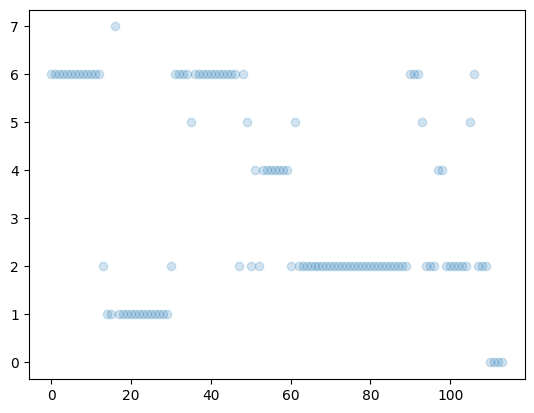

In [139]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(0,len(y_inference_upper_pred)), y_inference_upper_pred, alpha=0.2)

#### Stap 4. kNN

##### Lower

In [140]:
features_lower = ['x_left_hip','x_right_hip','x_left_knee','x_right_knee','x_left_ankle','x_right_ankle','y_left_hip','y_right_hip','y_left_knee','y_right_knee','y_left_ankle','y_right_ankle', 'H', 'I']
X_inference_lower = analytics_df[features_lower]
X_inference_lower

,x_left_hip,x_right_hip,x_left_knee,x_right_knee,x_left_ankle,x_right_ankle,y_left_hip,y_right_hip,y_left_knee,y_right_knee,y_left_ankle,y_right_ankle,H,I
0,0.297647,-0.462336,0.289349,-0.628867,0.138321,-0.506436,0.500000,0.495042,1.365249,1.371387,1.567836,1.553882,0.644757,0.004958
1,0.354930,-0.405895,0.456338,-0.557794,0.333006,-0.446832,0.492266,0.500000,1.308766,1.360138,1.509000,1.555999,0.779838,0.007734
2,0.369835,-0.378031,0.515618,-0.508897,0.442240,-0.367825,0.499907,0.500000,1.340966,1.342760,1.522497,1.509228,0.810065,0.000093
3,0.365503,-0.380511,0.495828,-0.528946,0.426637,-0.408169,0.498134,0.500000,1.359886,1.366788,1.571395,1.563149,0.834806,0.001866
4,0.337713,-0.394077,0.440319,-0.519883,0.265415,-0.486415,0.500000,0.494755,1.346669,1.340383,1.569871,1.547657,0.751830,0.005245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0.382576,-0.346872,0.237434,-0.381743,-0.084526,-0.281978,0.500000,0.496010,1.243665,1.202849,1.265260,1.230722,0.197452,0.003990
110,0.416221,-0.247681,0.218280,-0.302447,-0.069854,-0.203440,0.486178,0.500000,1.133649,1.165636,1.224602,1.224602,0.133586,0.013822
111,0.472786,-0.218570,0.237105,-0.275288,0.051541,0.010192,0.496303,0.500000,1.161809,1.149826,1.225596,1.225596,0.041348,0.003697
112,0.483441,-0.222428,0.326322,-0.288484,0.078167,-0.052237,0.500000,0.499022,1.115722,1.114265,1.185998,1.185998,0.130404,0.000978


In [141]:
# Pickle laden
# Keuze maken voor model

knn_lower = pickle.load(open('knn_lower_YOLOv8m.pkl', 'rb'))
#knn = pickle.load(open('knn_YOLOv8n.pkl', 'rb'))
knn_lower

KNeighborsClassifier(weights='distance')

In [142]:
y_inference_lower_pred = knn_lower.predict(X_inference_lower)

In [143]:
y_inference_lower_pred_proba = knn_lower.predict_proba(X_inference_lower)
y_inference_lower_pred_proba

array([[          0,           0,           0,           1],
       [          0,     0.21864,     0.59674,     0.18462],
       [          0,     0.39616,     0.60384,           0],
       [          0,     0.40275,     0.59725,           0],
       [          0,     0.21794,     0.58991,     0.19214],
       [          0,     0.58492,     0.41508,           0],
       [          0,     0.41136,     0.58864,           0],
       [          0,     0.40727,     0.59273,           0],
       [          0,     0.40794,     0.59206,           0],
       [          0,     0.22122,      0.3995,     0.37928],
       [          0,     0.58507,     0.41493,           0],
       [          0,     0.58059,     0.41941,           0],
       [          0,     0.40245,     0.59755,           0],
       [          0,     0.21691,     0.78309,           0],
       [          0,           0,           1,           0],
       [          0,     0.17103,     0.82897,           0],
       [          0,    

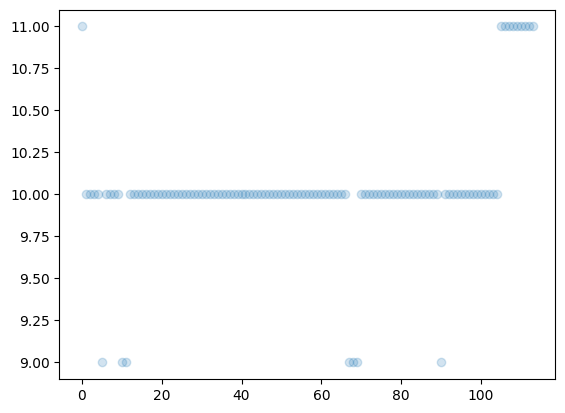

In [144]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(0,len(y_inference_lower_pred)), y_inference_lower_pred, alpha=0.2)

#### Stap 5. Feedback logica

##### Upper

In [145]:
poses_upper = {0: 'chin_up',
             1: 'crossed_arms',
             2: 'delivered_gestures',
             3: 'giving_the_back',
             4: 'hands_behind_back',
             5: 'hands_in_pockets',
             6: 'hands_loose',
             7: 'hands_touching_face'}

Pose found: hands_loose with probability: 1.0


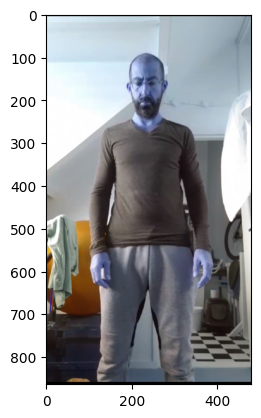

Pose found: crossed_arms with probability: 0.77


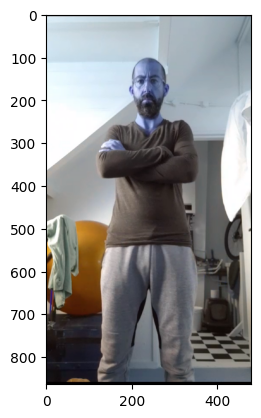

Pose found: hands_loose with probability: 0.64


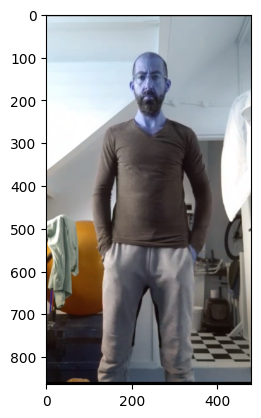

Pose found: hands_behind_back with probability: 0.55


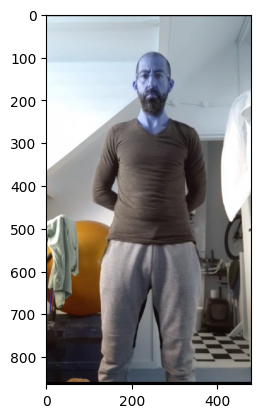

Pose found: delivered_gestures with probability: 0.86


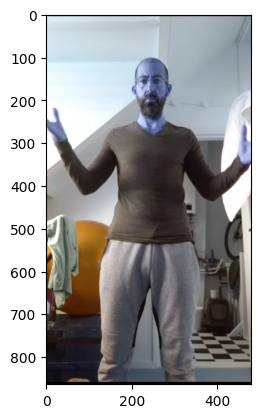

In [146]:
# Deze code kijkt binnen een gegeven aantal frames of een bepaalde pose vaak genoeg voor komt om er feedback over te geven

# Hulpvariabelen voor de loop
i = 0
previous_pose = -1

# Aantal frames waar naar gekeken wordt en de treshold voor het bepalen of een pose vaak genoeg voorgekomen is
number_frames = 10
treshold_frames = 7

# Loop over alle frames in de video
while i < len(y_inference_upper_pred) - number_frames:

    # y_inference_pred bevat alle voorspellingen.
    # Voor de voorspellingen i t/m i+number_frames wordt de modus bepaald: de voorspelling die het vaakst voor komt
    # Als de modus groter dan de treshold is, is er een pose gevonden die vaak genoeg voor komt in deze frames
    if stats.mode(y_inference_upper_pred[i:i+number_frames])[1] > treshold_frames:

        # Als de gevonden pose hetzelfde is als previous_pose, hoeft er niks te gebeuren: dat betekent dat de pose langer dan number_frames aanhoudt
        if stats.mode(y_inference_upper_pred[i:i+number_frames])[0] != previous_pose:

            # previous_pose wordt in dit geval overschreven met de nieuw gevonden pose
            previous_pose = int(stats.mode(y_inference_upper_pred[i:i+number_frames])[0])

            # berekening van de probability van de gevonden pose door te kijken naar de gemiddelde proba uit y_inference_pred_proba
            proba = np.round(y_inference_upper_pred_proba[i:i+number_frames,previous_pose].mean(),2)
            print("Pose found: " + poses_upper[previous_pose] +
                  " with probability: " + str(proba))

            # Ophalen frame om te tonen
            image = Image.fromarray(results_inference[int(analytics_df['frame_number'].loc[i+number_frames//2])].orig_img).convert('RGB')
            plt.imshow(image)
            plt.show()

        i = i + number_frames
    else: i = i + 1

#### Stap 5. Feedback logica

##### Lower

In [147]:
poses_lower = {8: 'crossing_legs',
             9: 'feet_neutral',
             10: 'feet_not_neutral',
             11: 'bodyweight_one_leg'}


Pose found: feet_not_neutral with probability: 0.5


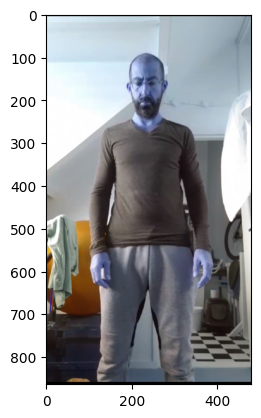

Pose found: bodyweight_one_leg with probability: 0.58


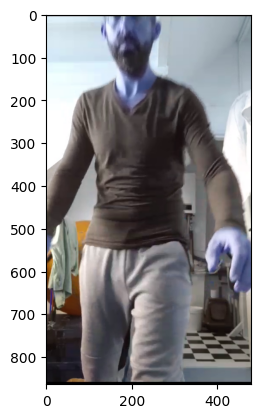

In [148]:
# Deze code kijkt binnen een gegeven aantal frames of een bepaalde pose vaak genoeg voor komt om er feedback over te geven

# Hulpvariabelen voor de loop
i = 0
previous_pose = -1

# Aantal frames waar naar gekeken wordt en de treshold voor het bepalen of een pose vaak genoeg voorgekomen is
number_frames = 10
treshold_frames = 7

# Loop over alle frames in de video
while i < len(y_inference_lower_pred) - number_frames:

    # y_inference_pred bevat alle voorspellingen.
    # Voor de voorspellingen i t/m i+number_frames wordt de modus bepaald: de voorspelling die het vaakst voor komt
    # Als de modus groter dan de treshold is, is er een pose gevonden die vaak genoeg voor komt in deze frames
    if stats.mode(y_inference_lower_pred[i:i+number_frames])[1] > treshold_frames:

        # Als de gevonden pose hetzelfde is als previous_pose, hoeft er niks te gebeuren: dat betekent dat de pose langer dan number_frames aanhoudt
        if stats.mode(y_inference_lower_pred[i:i+number_frames])[0] != previous_pose:

            # previous_pose wordt in dit geval overschreven met de nieuw gevonden pose
            previous_pose = int(stats.mode(y_inference_lower_pred[i:i+number_frames])[0])

            # berekening van de probability van de gevonden pose door te kijken naar de gemiddelde proba uit y_inference_pred_proba
            # Let op: previous_pose heeft nu waarde tussen 8 en 11 en dat moet gemapt worden naar 0 t/m 3 omdat er hier maar 4 poses zijn
            proba = np.round(y_inference_lower_pred_proba[i:i+number_frames,(previous_pose-8)].mean(),2)
            print("Pose found: " + poses_lower[previous_pose] +
                  " with probability: " + str(proba))

            # Ophalen frame om te tonen
            image = Image.fromarray(results_inference[int(analytics_df['frame_number'].loc[i+number_frames//2])].orig_img).convert('RGB')
            plt.imshow(image)
            plt.show()

        i = i + number_frames
    else: i = i + 1